ЦК ПиМОП занимается прогнозированием финансового результата в разрезе до отдельных статей дохода для всех территориальных подразделений. 
Вам предлагается сформировать прогноз для всех подразделений на примере одной статьи.


В приложенном .xlsx-файле есть два листа: months и days. Смысл полей:
*   report_dt: отчётная дата (конец месяца для месячных данных и день для дневных);
*   territ_subdiv_1: первый уровень дробления по территориям;
*   territ_subdiv_2: второй уровень дробления по территориям. Обратите внимание на нумерацию: в разных подразделениях первого уровня содержится разное число подразделений второго уровня;
*   val: комиссионный доход.

##Задание:
Для представленных на листе months месячных данных сформируйте помесячный прогноз на 2020 год для всех подразделений.
Для ноября 2020 года в начале года был сформирован прогноз 3188.91. Используя дневные данные на листе days, уточните этот прогноз.


###Импорт библиотек

In [1]:
import pandas as pd 
import numpy as np 
import sys
import warnings
import itertools
warnings.filterwarnings("ignore")

from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.dates import DateFormatter

import datetime
import calendar
import seaborn as sns

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Загрузка данных

In [17]:
dfname=pd.ExcelFile('/content/drive/My Drive/2_5393425784910121785.xlsx') #загружаем файл
print(dfname.sheet_names) #какие листы есть в файле

['months', 'days']


In [18]:
days=pd.read_excel('/content/drive/My Drive/2_5393425784910121785.xlsx',sheet_name='days')
days

report_dt  territ_subdiv_1  territ_subdiv_2       val
0     2019-05-31                1                1  1.000000
1     2019-05-31                1                2  1.000000
2     2019-05-31                1                3  1.000000
3     2019-05-31                1                4  1.000000
4     2019-05-31                1                5  1.000000
...          ...              ...              ...       ...
40968 2020-11-21               11                4  1.473936
40969 2020-11-21               11                5  1.224346
40970 2020-11-21               11                6  1.154639
40971 2020-11-21               11                7  1.288267
40972 2020-11-21               11                8  1.305227

[40973 rows x 4 columns]

In [19]:
days.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40973 entries, 0 to 40972
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   report_dt        40973 non-null  datetime64[ns]
 1   territ_subdiv_1  40973 non-null  int64         
 2   territ_subdiv_2  40973 non-null  int64         
 3   val              40973 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 1.3 MB


In [20]:
days.describe()

territ_subdiv_1  territ_subdiv_2           val
count     40973.000000     40973.000000  40973.000000
mean          6.449540         5.328851      1.258391
std           3.037036         3.143999      0.417794
min           1.000000         1.000000      0.134688
25%           5.000000         3.000000      1.016003
50%           7.000000         5.000000      1.133837
75%           9.000000         8.000000      1.320846
max          11.000000        15.000000      4.160394

In [21]:
days.isna().sum()

report_dt          0
territ_subdiv_1    0
territ_subdiv_2    0
val                0
dtype: int64

Пустых ячеек нет, это хорошо

In [22]:
#сколько всего поразделений первого уровня
SD1_unique = days.territ_subdiv_1.unique() #список уникальных подразделений 1 уровня
SD1_num = len(SD1_unique) #количество подразделений 1 уровня
num = 0 #общий счётчик подразделений

#сколько поразделений второго уровня в подразделениях первого уровня
for SD1 in SD1_unique:
  SD2_unique = days[(days.territ_subdiv_1)==SD1].territ_subdiv_2.unique() #список уникальных подразделений 2 уровня
  SD2_num = len(SD2_unique) #количество подразделений 2 уровня
  print('В подразделении ', SD1, 'всего ', SD2_num, 'подразделений второго уровня:', SD2_unique)
  num += SD2_num
print('')
print('Всего', SD1_num, 'подразделений первого уровня:', SD1_unique)
print('Всего', num, 'подразделений')

В подразделении  1 всего  6 подразделений второго уровня: [1 2 3 4 5 6]
В подразделении  2 всего  9 подразделений второго уровня: [1 2 3 4 5 6 7 8 9]
В подразделении  3 всего  4 подразделений второго уровня: [1 2 3 4]
В подразделении  4 всего  1 подразделений второго уровня: [2]
В подразделении  5 всего  15 подразделений второго уровня: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
В подразделении  6 всего  9 подразделений второго уровня: [ 2  3  4  5  6  7  8  9 10]
В подразделении  7 всего  8 подразделений второго уровня: [1 2 3 4 5 6 7 8]
В подразделении  8 всего  11 подразделений второго уровня: [ 1  2  3  4  5  6  7  8  9 10 11]
В подразделении  9 всего  8 подразделений второго уровня: [1 2 3 4 5 6 7 8]
В подразделении  10 всего  10 подразделений второго уровня: [ 1  2  3  4  5  6  7  8  9 10]
В подразделении  11 всего  8 подразделений второго уровня: [1 2 3 4 5 6 7 8]

Всего 11 подразделений первого уровня: [ 1  2  3  4  5  6  7  8  9 10 11]
Всего 89 подразделений


In [23]:
#превращаем колонку с датой в DateTimeIindex
days.index = pd.to_datetime(days.report_dt) 
days.drop('report_dt', axis=1, inplace=True)
days.head()

territ_subdiv_1  territ_subdiv_2  val
report_dt                                        
2019-05-31                1                1  1.0
2019-05-31                1                2  1.0
2019-05-31                1                3  1.0
2019-05-31                1                4  1.0
2019-05-31                1                5  1.0

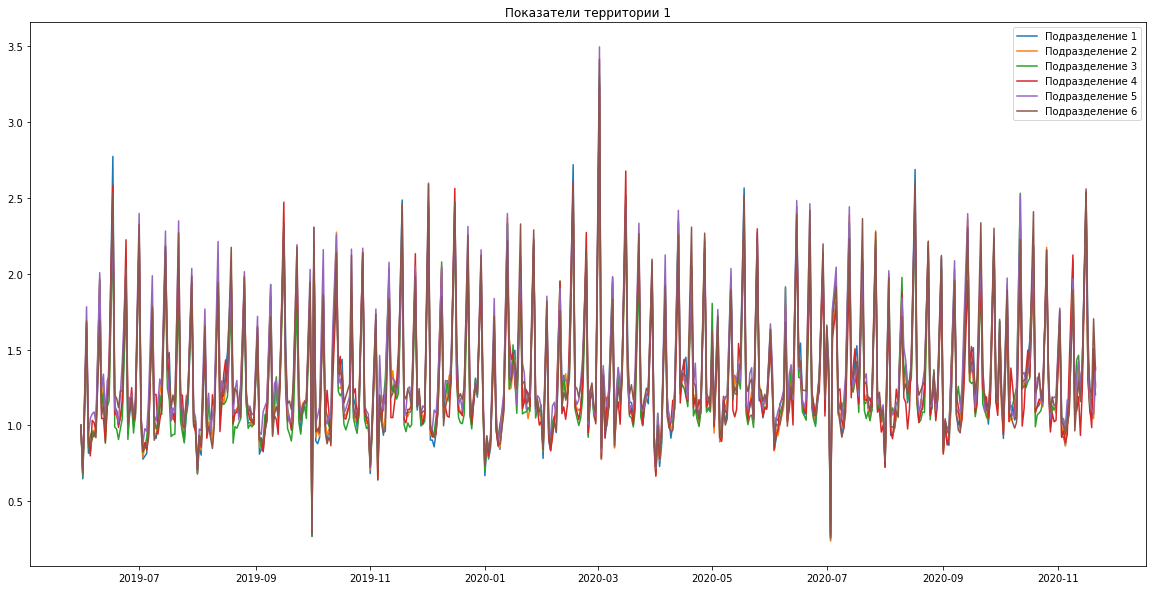

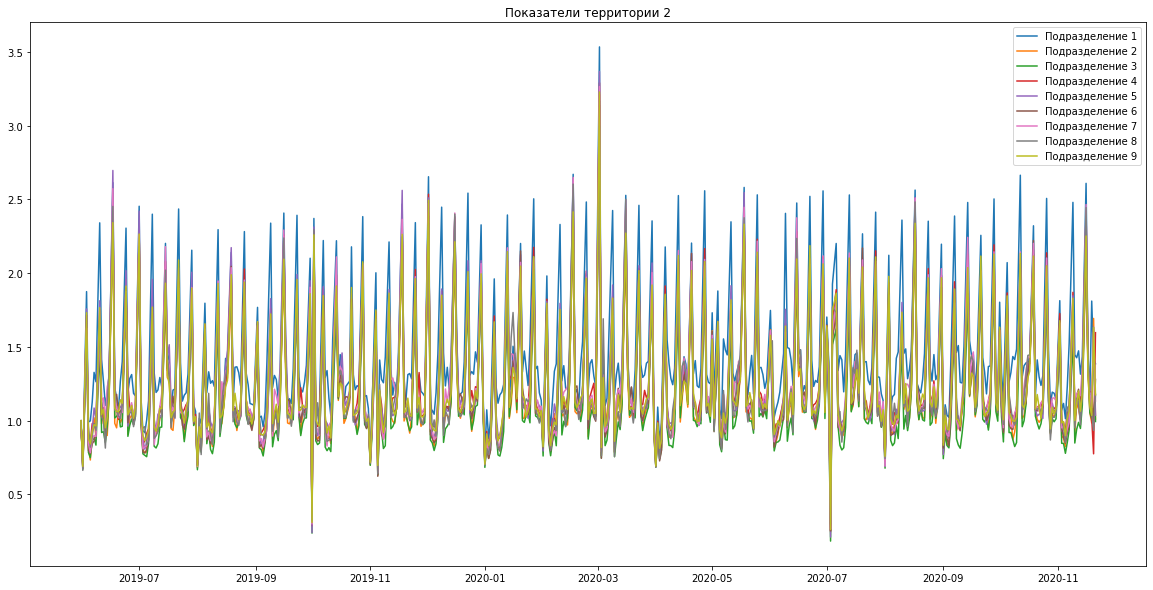

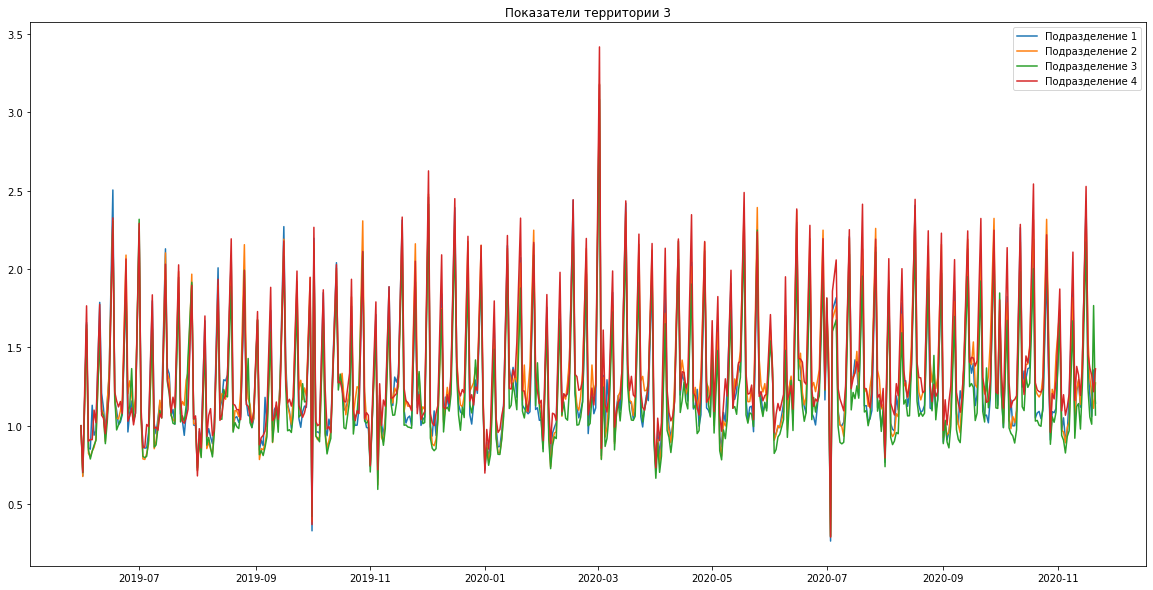

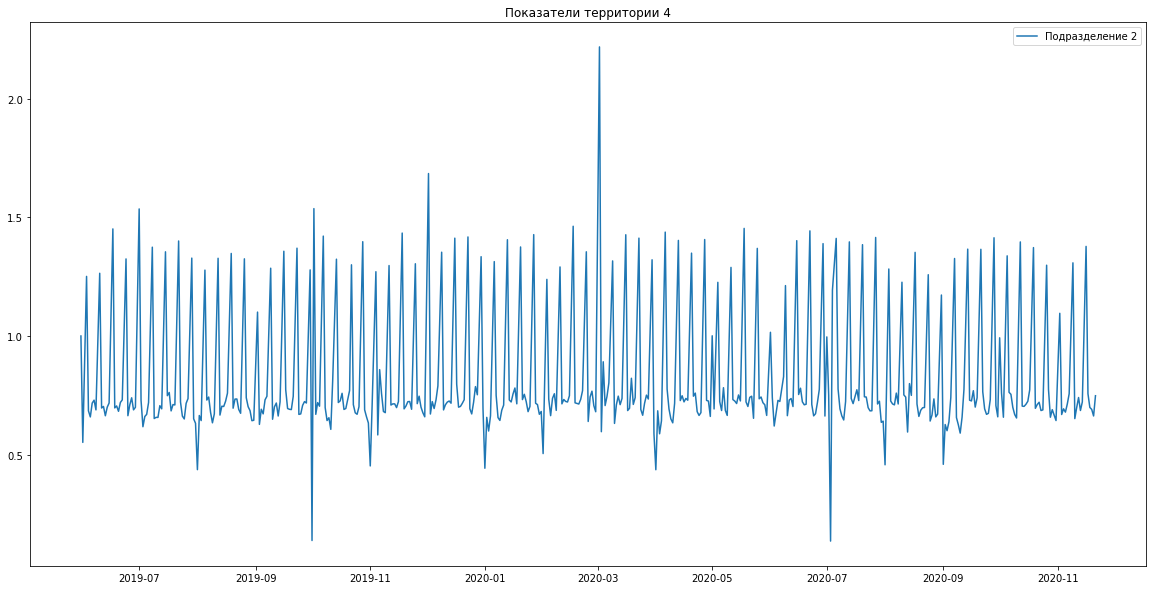

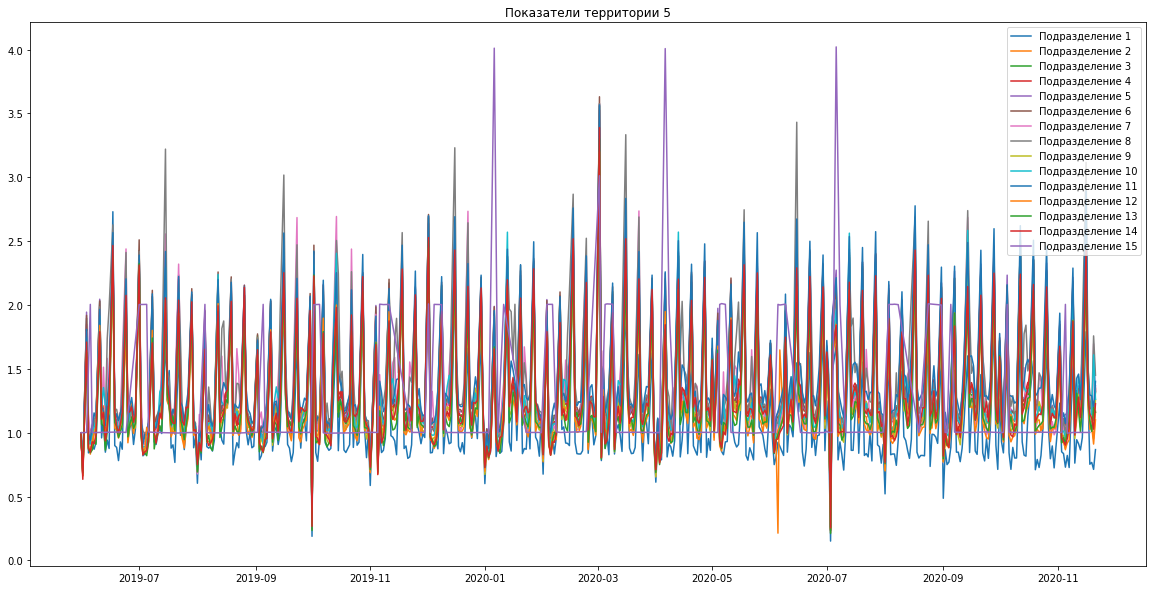

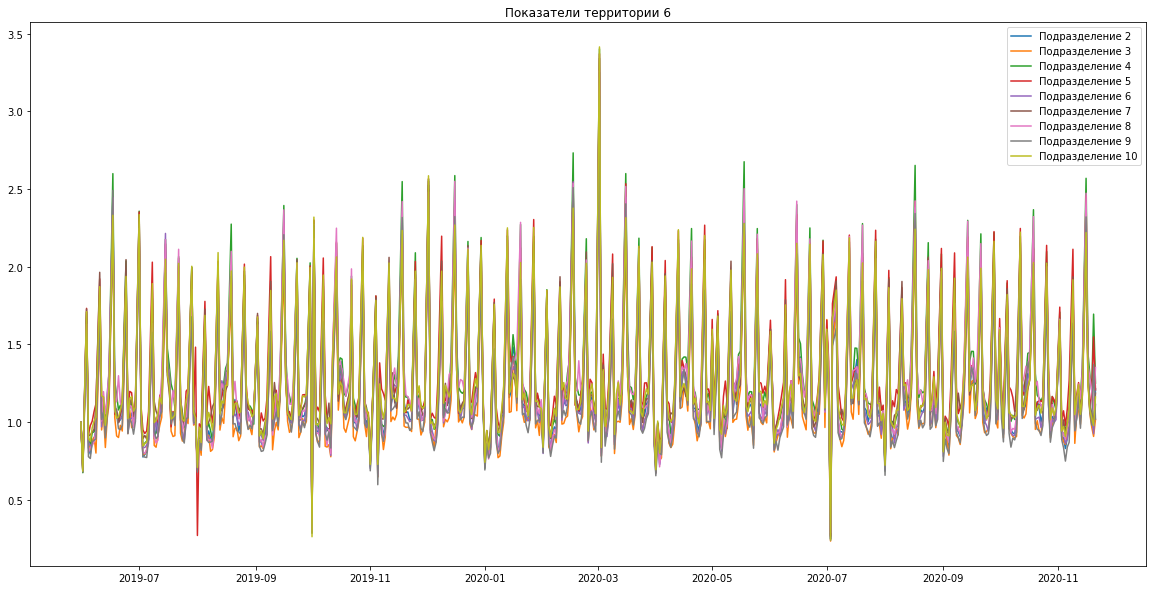

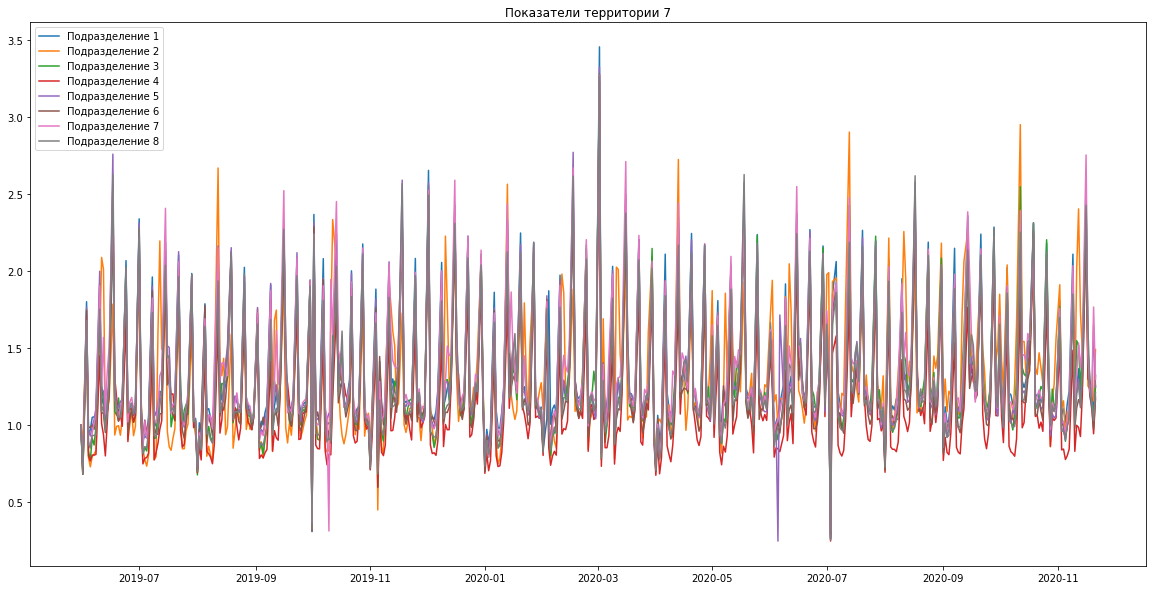

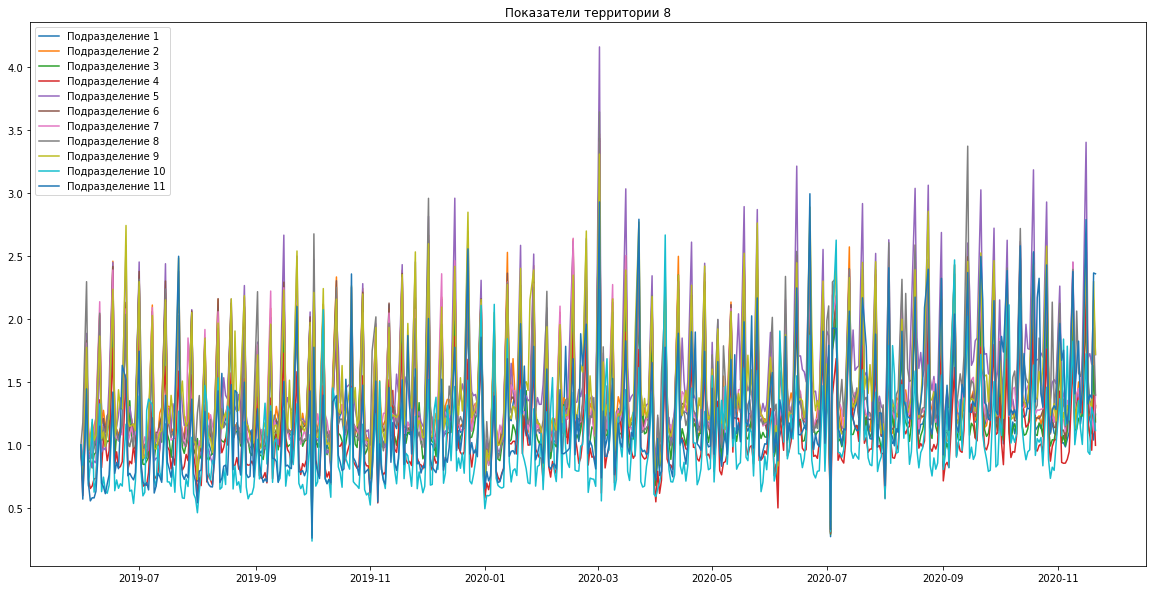

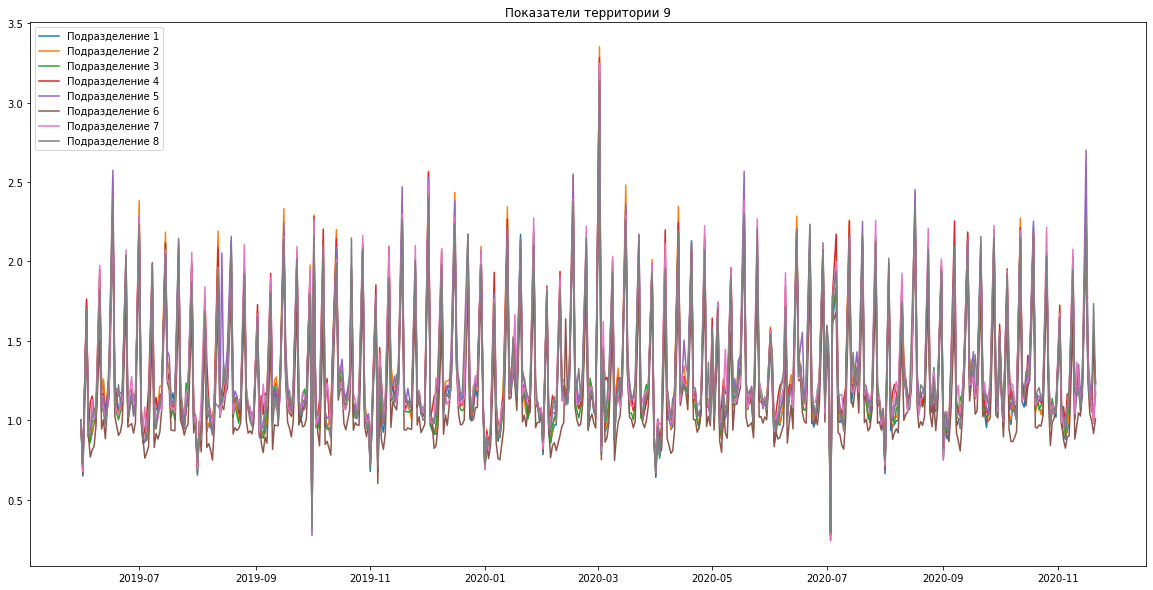

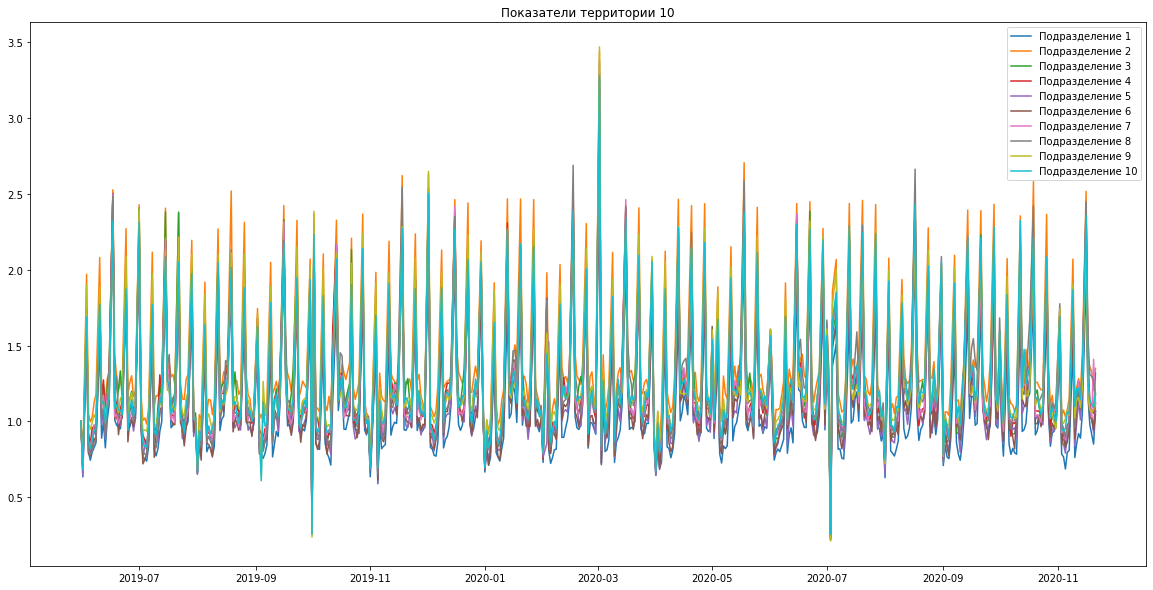

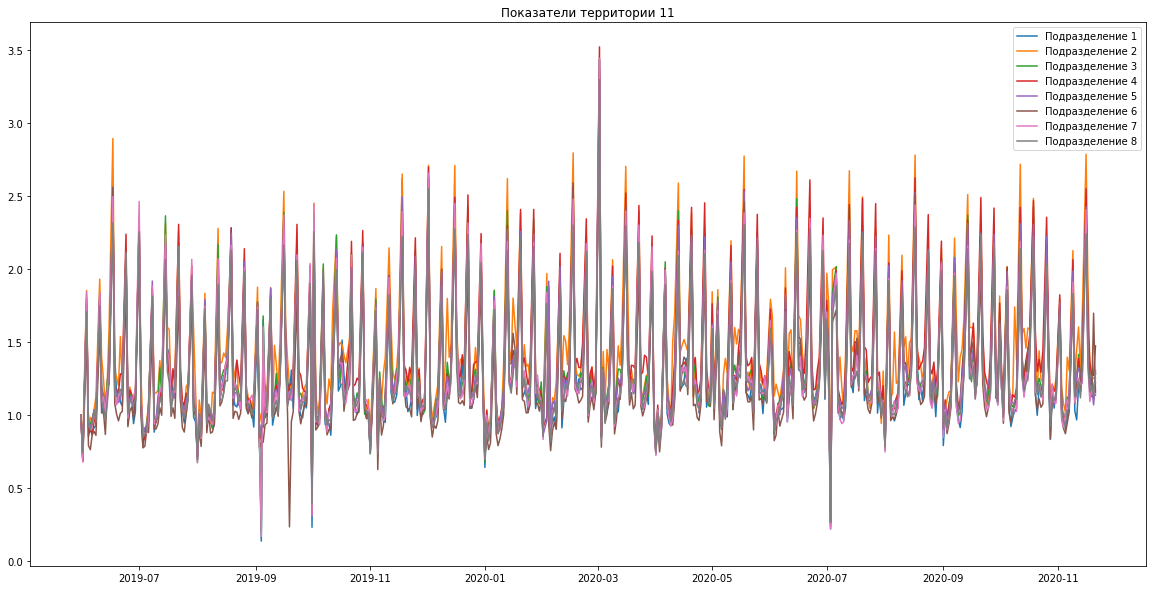

In [24]:
for SD1 in SD1_unique:
  DF_SD1 = pd.DataFrame(days[((days.territ_subdiv_1)==SD1)]) #датафрейм, содержащий все подразделения данной территории
  SD2_unique = DF_SD1.territ_subdiv_2.unique() #список уникальных подразделений 2 уровня 
  
  # построим графики
  plt.figure(figsize=(20,10))
  plt.title(f'Показатели территории {SD1}')
  
  # Создадим отдельный файл с данными для каждого подразделения
  for SD2 in SD2_unique: # для каждого подразделения в списке для данной территории
    export_file_path = str(SD1) + '-' + str(SD2) # определяем название файла
    
    DF = pd.DataFrame(DF_SD1[((DF_SD1.territ_subdiv_2)==SD2)]) #датафрейм с данными подразделения
    DF.to_csv(export_file_path, columns=['val']) #записываем в файл
    
    data_to_read = pd.read_csv(export_file_path)
    data_to_read.index = pd.to_datetime(data_to_read.report_dt) 
    data_to_read.drop('report_dt', axis=1, inplace=True)
    
    plt.plot(data_to_read, label=f'Подразделение {SD2}') # строим график для данного подразделения 
    plt.legend()
  
  # выведем данные на графике
 
  plt.legend()
  plt.show()

###Тренд и сезонность
Растущий тренд, в общем, очевиден, выраженной сезонности не заметно

In [27]:
dates = days.index
days['Year']= dates.year
days['Month']= dates.month
days['Month'] = days['Month'].apply(lambda x: calendar.month_abbr[x])
data = days[['Month','Year','territ_subdiv_1',	'val']]
# data = days[['Month','Year',	'val']]
monthly_data = pd.pivot_table(data, values = "val", columns = ["Year",'territ_subdiv_1'], index = "Month")
# monthly_data = pd.pivot_table(data, values = "val", columns = ["Year"], index = "Month")
monthly_data = monthly_data.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

monthly_data

Year                 2019                      ...      2020                    
territ_subdiv_1        1         2         3   ...        9         10        11
Month                                          ...                              
Jan                   NaN       NaN       NaN  ...  1.210264  1.184482  1.262786
Feb                   NaN       NaN       NaN  ...  1.231871  1.207402  1.296698
Mar                   NaN       NaN       NaN  ...  1.329006  1.306208  1.399883
Apr                   NaN       NaN       NaN  ...  1.211894  1.194583  1.283165
May              1.000000  1.000000  1.000000  ...  1.260306  1.241381  1.336087
Jun              1.200831  1.170767  1.177522  ...  1.273025  1.245013  1.351221
Jul              1.242685  1.215404  1.219586  ...  1.268834  1.241584  1.347410
Aug              1.186754  1.159040  1.165642  ...  1.277852  1.249109  1.357890
Sep              1.253313  1.215805  1.225124  ...  1.251713  1.219321  1.331134
Oct              1.246237  1.207526  1.224915  ...  1.271279  1.236234  1.357329
Nov              1.233277  1.188674  1.208361  ...  1.257575  1.208398  1.336364
Dec              1.347079  1.302133  1.333153  ...       NaN       NaN       NaN

[12 rows x 22 columns]

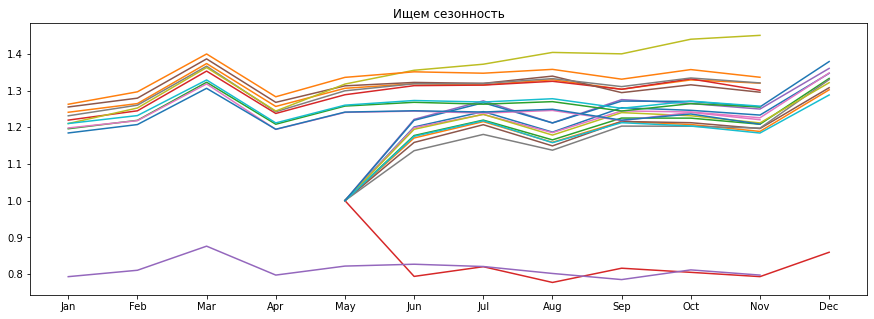

In [28]:
plt.figure(figsize=(15,5))
plt.plot(monthly_data)
plt.title('Ищем сезонность')
plt.show()

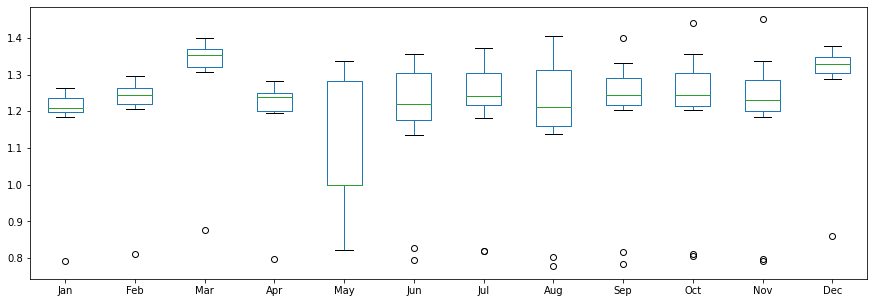

In [29]:
monthly_data.T.boxplot(grid=False, figsize=(15,5))
plt.show()

In [31]:
dates = days.index
days['Year']= dates.year
days['Month']= dates.month
days['Month'] = days['Month'].apply(lambda x: calendar.month_abbr[x])
days['Day']= dates.day

daily_data = days.pivot_table('val', dates, ['territ_subdiv_1', 'territ_subdiv_2'] )
# daily_data = days.pivot_table('val', dates)

daily_data

daily_data

territ_subdiv_1        1                       ...        11                    
territ_subdiv_2         1         2         3  ...         6         7         8
report_dt                                      ...                              
2019-05-31       1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000
2019-06-01       0.647234  0.672398  0.659519  ...  0.681274  0.680265  0.742855
2019-06-03       1.568463  1.588431  1.649000  ...  1.573696  1.842575  1.707561
2019-06-04       0.816246  0.857406  0.848363  ...  0.791749  0.932600  0.932414
2019-06-05       0.823131  0.831198  0.932138  ...  0.763148  0.903117  0.898103
...                   ...       ...       ...  ...       ...       ...       ...
2020-11-17       1.597701  1.337752  1.315637  ...  1.555240  1.332677  1.342548
2020-11-18       1.210856  1.159224  1.087825  ...  1.174591  1.092864  1.162678
2020-11-19       1.094876  1.120614  1.044319  ...  1.125925  1.170783  1.204255
2020-11-20       1.508113  1.044103  1.409717  ...  1.697773  1.139698  1.130156
2020-11-21       1.249404  1.265885  1.201827  ...  1.154639  1.288267  1.305227

[464 rows x 89 columns]

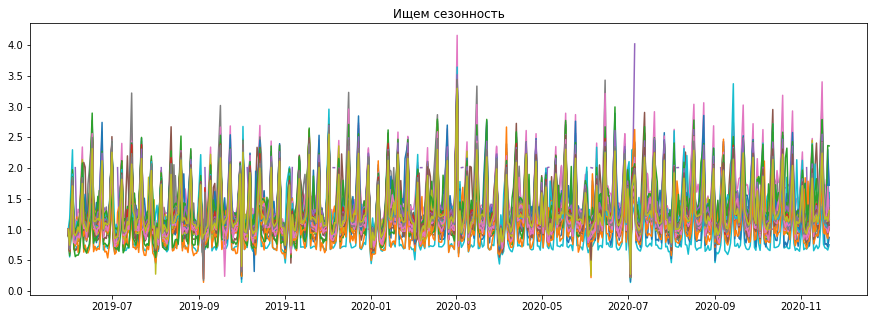

In [32]:
plt.figure(figsize=(15,5))
plt.plot(daily_data)
plt.title('Ищем сезонность')
plt.show()

In [33]:
daily_data_SD1 = days.pivot_table('val', 'Day')

daily_data_SD1

val
Day          
1    1.065743
2    1.475346
3    1.037462
4    1.115989
5    1.063051
6    1.188190
7    1.165237
8    1.082863
9    1.275614
10   1.152218
11   1.225084
12   1.334057
13   1.331965
14   1.329091
15   1.393717
16   1.580527
17   1.531990
18   1.293326
19   1.247658
20   1.288651
21   1.211993
22   1.362293
23   1.304433
24   1.269940
25   1.188573
26   1.249846
27   1.369942
28   1.229516
29   1.229867
30   1.247924
31   1.140415

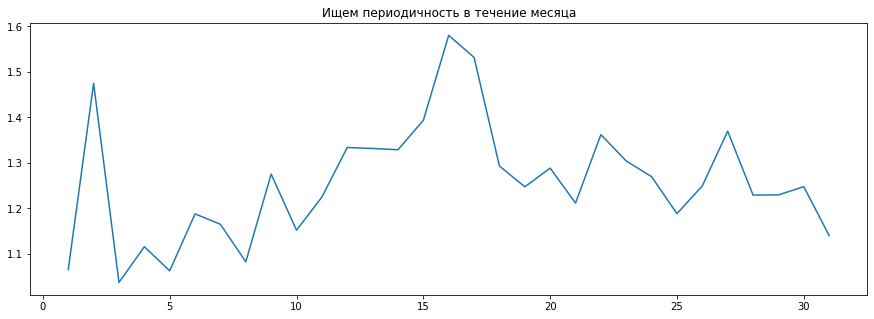

In [35]:
plt.figure(figsize=(15,5))
plt.plot(daily_data_SD1)
plt.title('Ищем периодичность в течение месяца')
plt.show()

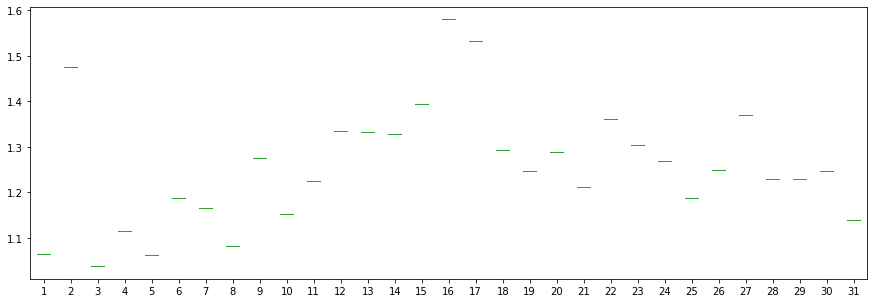

In [37]:
plt.figure(figsize=(15,5))
daily_data_SD1.T.boxplot(grid=False, figsize=(10,6))
plt.show()

In [38]:
monthly_data = days.pivot_table('val', 'Month', ['territ_subdiv_1', 'territ_subdiv_2'] )
monthly_data = monthly_data.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
monthly_data

territ_subdiv_1        1                       ...        11                    
territ_subdiv_2         1         2         3  ...         6         7         8
Month                                          ...                              
Jan              1.226742  1.223806  1.216837  ...  1.172317  1.243559  1.231345
Feb              1.252298  1.246818  1.240549  ...  1.197771  1.266681  1.255463
Mar              1.362326  1.350963  1.354015  ...  1.298135  1.378260  1.359084
Apr              1.245006  1.242997  1.231962  ...  1.190734  1.259988  1.239767
May              1.284475  1.279452  1.280722  ...  1.234880  1.289673  1.279775
Jun              1.244383  1.247350  1.226295  ...  1.190297  1.268262  1.252730
Jul              1.261707  1.264556  1.245500  ...  1.213122  1.293766  1.270043
Aug              1.241643  1.243413  1.227290  ...  1.196115  1.261376  1.248942
Sep              1.264382  1.264465  1.254317  ...  1.198792  1.275338  1.265306
Oct              1.272404  1.270150  1.267970  ...  1.235730  1.283592  1.273426
Nov              1.260288  1.242262  1.261922  ...  1.226522  1.254968  1.243908
Dec              1.331617  1.327308  1.321034  ...  1.279692  1.353794  1.339599

[12 rows x 89 columns]

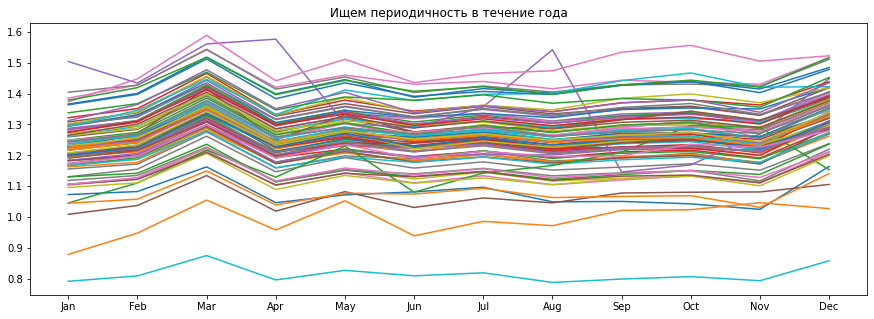

In [39]:
plt.figure(figsize=(15,5))
plt.plot(monthly_data)
plt.title('Ищем периодичность в течение года')
plt.show()

In [40]:
monthly_data_SD1 = days.pivot_table('val', 'Month', ['territ_subdiv_1'])

monthly_data_SD1 = monthly_data_SD1.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
monthly_data_SD1

territ_subdiv_1        1         2         3   ...        9         10        11
Month                                          ...                              
Jan              1.240922  1.195952  1.219495  ...  1.210264  1.184482  1.262786
Feb              1.264577  1.218908  1.244893  ...  1.231871  1.207402  1.296698
Mar              1.373788  1.322701  1.353229  ...  1.329006  1.306208  1.399883
Apr              1.256778  1.208284  1.237678  ...  1.211894  1.194583  1.283165
May              1.294929  1.248256  1.278018  ...  1.250665  1.232441  1.323639
Jun              1.260920  1.220376  1.246825  ...  1.234516  1.210862  1.286409
Jul              1.279126  1.239176  1.267293  ...  1.252056  1.229756  1.307141
Aug              1.256792  1.213416  1.243989  ...  1.227350  1.202690  1.283461
Sep              1.279002  1.230349  1.265126  ...  1.245989  1.215966  1.301860
Oct              1.287667  1.235956  1.278455  ...  1.251359  1.219862  1.313919
Nov              1.268880  1.215991  1.246219  ...  1.230556  1.194156  1.288614
Dec              1.347079  1.302133  1.333153  ...  1.321661  1.288050  1.379202

[12 rows x 11 columns]

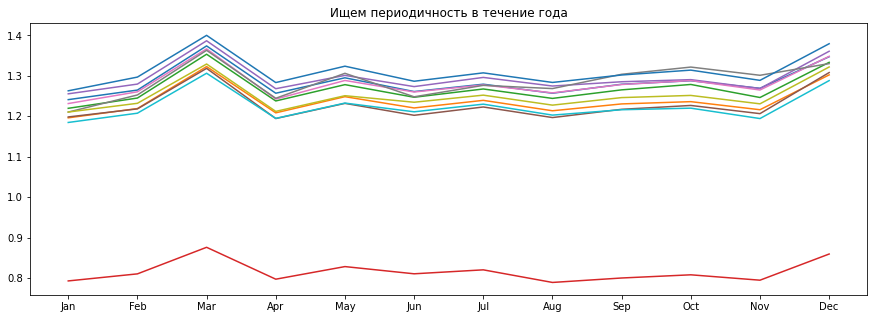

In [41]:
plt.figure(figsize=(15,5))
plt.plot(monthly_data_SD1)
plt.title('Ищем периодичность в течение года')
plt.show()

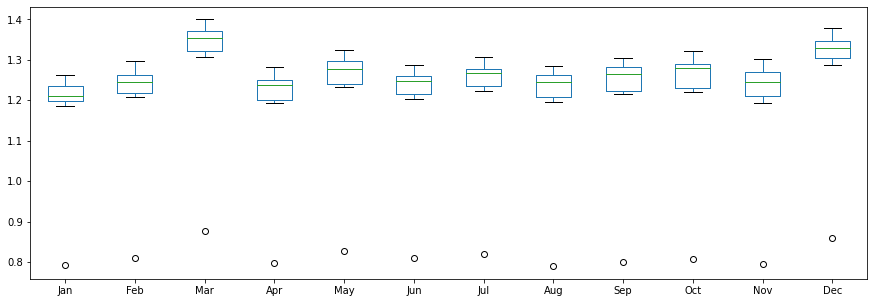

In [42]:
plt.figure(figsize=(15,5))
monthly_data_SD1.T.boxplot(grid=False, figsize=(10,6))
plt.show()

На графиках видны пики 2 и 16-17 числа каждого месяца и в марте и декабре каждого года.

In [43]:
days

territ_subdiv_1  territ_subdiv_2       val  Year Month  Day
report_dt                                                              
2019-05-31                1                1  1.000000  2019   May   31
2019-05-31                1                2  1.000000  2019   May   31
2019-05-31                1                3  1.000000  2019   May   31
2019-05-31                1                4  1.000000  2019   May   31
2019-05-31                1                5  1.000000  2019   May   31
...                     ...              ...       ...   ...   ...  ...
2020-11-21               11                4  1.473936  2020   Nov   21
2020-11-21               11                5  1.224346  2020   Nov   21
2020-11-21               11                6  1.154639  2020   Nov   21
2020-11-21               11                7  1.288267  2020   Nov   21
2020-11-21               11                8  1.305227  2020   Nov   21

[40973 rows x 6 columns]

In [44]:
days['dayofweek'] = days.index.dayofweek
weekly_data = days.pivot_table('val', 'dayofweek', ['territ_subdiv_1', 'territ_subdiv_2'])
monthly_data = monthly_data.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
weekly_data

territ_subdiv_1        1                       ...        11                    
territ_subdiv_2         1         2         3  ...         6         7         8
dayofweek                                      ...                              
0                2.032323  2.027834  2.022304  ...  1.924706  2.087224  2.032391
1                1.121457  1.112453  1.106876  ...  1.103557  1.143724  1.141502
2                1.120320  1.120697  1.106573  ...  1.068358  1.111294  1.108000
3                1.097060  1.100223  1.095060  ...  1.044764  1.111772  1.094972
4                1.088137  1.082503  1.082605  ...  1.062693  1.101342  1.092816
5                1.142534  1.141030  1.127230  ...  1.097272  1.140590  1.141299

[6 rows x 89 columns]

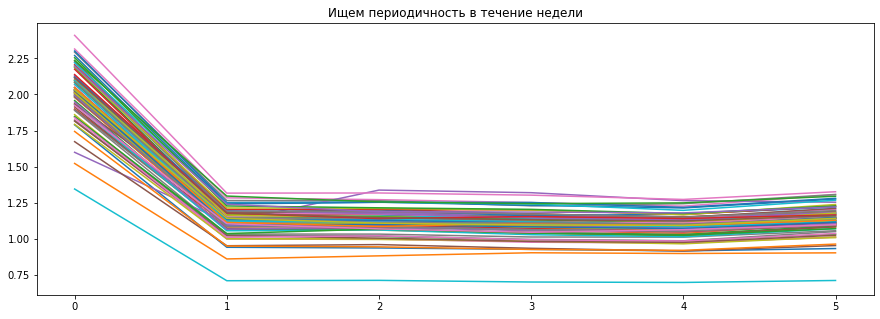

In [45]:
plt.figure(figsize=(15,5))
plt.plot(weekly_data)
plt.title('Ищем периодичность в течение недели')
plt.show()

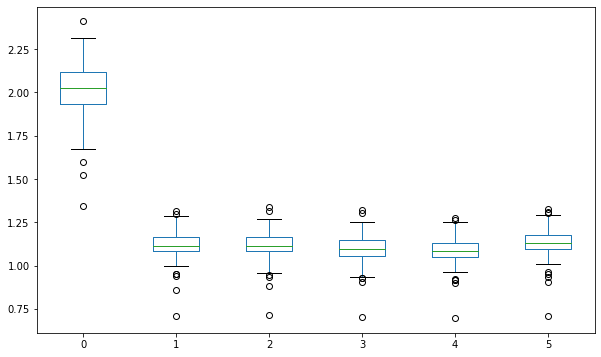

In [46]:
weekly_data.T.boxplot(grid=False, figsize=(10,6))
plt.show()

In [47]:
data_to_explore = days[((days.territ_subdiv_1==1)&(days.territ_subdiv_2==1))]
data_to_explore.drop(columns=['territ_subdiv_1','territ_subdiv_2','Year', 'Month', 'Day', 'dayofweek'], inplace=True)
data_to_explore

val
report_dt           
2019-05-31  1.000000
2019-06-01  0.647234
2019-06-03  1.568463
2019-06-04  0.816246
2019-06-05  0.823131
...              ...
2020-11-17  1.597701
2020-11-18  1.210856
2020-11-19  1.094876
2020-11-20  1.508113
2020-11-21  1.249404

[464 rows x 1 columns]

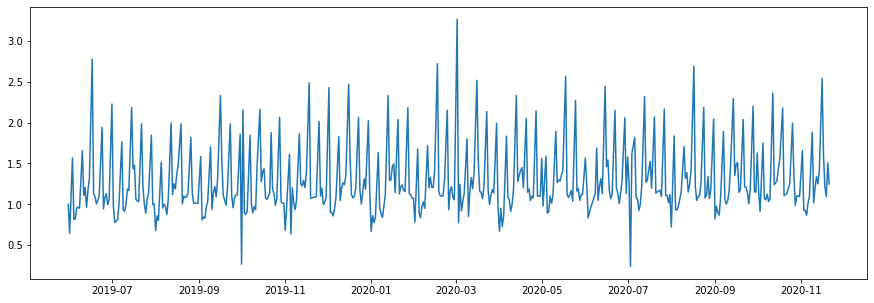

In [48]:
plt.figure(figsize=(15,5))
plt.plot(data_to_explore)
plt.show()

###Моделирование

In [ ]:
train = (data_to_explore[data_to_explore.index < '2020-10-01']) #тренировочные данные
test = (data_to_explore[data_to_explore.index >= '2020-10-01']) #тестовые данные

In [50]:
# Определим параметры для модели
model = AR(train)
model_fit = model.fit()

# Количество лагов, их значения
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params) 

Lag: 17
Coefficients: const      1.763870
L1.val     0.011745
L2.val     0.137977
L3.val     0.057945
L4.val     0.057578
L5.val    -0.038181
L6.val     0.270365
L7.val    -0.259729
L8.val    -0.213641
L9.val    -0.067489
L10.val   -0.106814
L11.val   -0.143538
L12.val    0.398868
L13.val    0.054088
L14.val   -0.140391
L15.val   -0.210606
L16.val   -0.183812
L17.val   -0.022213
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [51]:
# сделаем прогноз на тестовых данных
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [52]:
predictions

419    1.116994
420    0.924074
421    0.997324
422    1.773648
423    0.996914
424    1.047155
425    1.055021
426    0.911003
427    1.089638
428    1.954955
429    1.222753
430    1.193878
431    1.171168
432    1.026766
433    1.191086
434    1.893548
435    1.225429
436    1.206092
437    1.212563
438    1.064990
439    1.217780
440    1.893183
441    1.290324
442    1.218435
443    1.173553
444    1.006663
445    1.166308
446    1.769117
447    1.213365
448    1.138709
449    1.126652
450    0.993268
451    1.162423
452    1.732049
453    1.246892
454    1.169942
455    1.146814
456    1.007897
457    1.181662
458    1.712981
459    1.276018
460    1.188805
461    1.170185
462    1.048398
463    1.223589
dtype: float64

In [101]:
# test_ind=test
# test_ind ['index']=pd.DataFrame(index_test, )

# test_ind = pd.DataFrame(test)
# test_ind.test_ind.rename_axis('index').reset_index()
# test_ind.index=list(range(419,464))
predictions_ind=predictions
predictions_ind.index=test.index
# predictions_ind
test

val
report_dt           
2020-10-01  1.628899
2020-10-02  1.143530
2020-10-03  0.913719
2020-10-05  1.748833
2020-10-06  1.074414
2020-10-07  1.054121
2020-10-08  1.125276
2020-10-09  1.035048
2020-10-10  1.063938
2020-10-12  2.359303
2020-10-13  1.240816
2020-10-14  1.262012
2020-10-15  1.294378
2020-10-16  1.442463
2020-10-17  1.553979
2020-10-19  2.177330
2020-10-20  1.107583
2020-10-21  1.118938
2020-10-22  1.132891
2020-10-23  1.195752
2020-10-24  1.253967
2020-10-26  1.991933
2020-10-27  1.329599
2020-10-28  0.988097
2020-10-29  1.098630
2020-10-30  1.107845
2020-10-31  1.094801
2020-11-02  1.657540
2020-11-03  0.927120
2020-11-04  0.924260
2020-11-05  0.867204
2020-11-06  1.012421
2020-11-07  1.102310
2020-11-09  1.881897
2020-11-10  1.017893
2020-11-11  1.205406
2020-11-12  1.341774
2020-11-13  1.249757
2020-11-14  1.401512
2020-11-16  2.538432
2020-11-17  1.597701
2020-11-18  1.210856
2020-11-19  1.094876
2020-11-20  1.508113
2020-11-21  1.249404

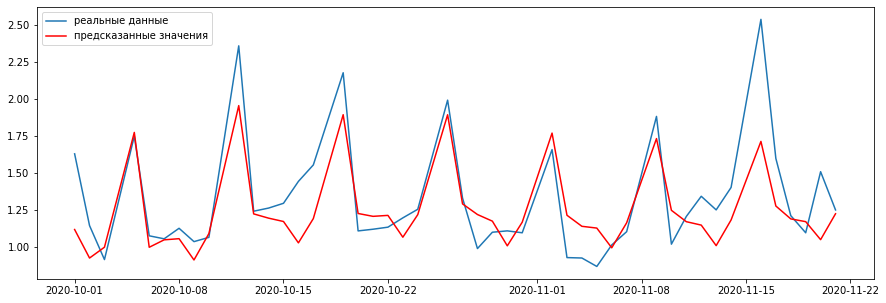

In [102]:
# выведем результаты на графике
plt.figure(figsize=(15,5))
plt.plot(test, label='реальные данные')
plt.plot(predictions, color='red', label='предсказанные значения')
plt.legend()
plt.show()

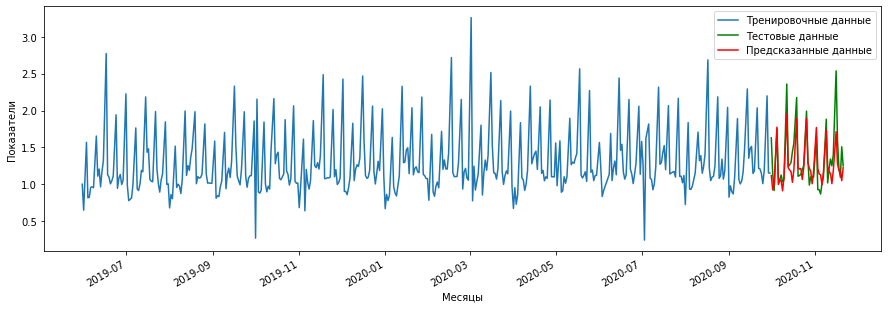

In [106]:
axis = train['val'].plot(label='Тренировочные данные', figsize=(15, 5))
test['val'].plot(ax=axis, label='Тестовые данные', color='g')
predictions.plot(ax=axis, label='Предсказанные данные', color='r')
axis.set_xlabel('Месяцы')
axis.set_ylabel('Показатели')
plt.legend(loc='best')
plt.show()
plt.close()

In [103]:
# Посчитаем ошибку для полученной модели

# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['val'], predictions))
rmse = round(rmse, 3)
      
# Mean Absolute Percentage Error
abs_error = np.abs(test['val']-predictions)
actual = test['val']
mape = np.round(np.mean(abs_error/actual),3)

#Запишем результаты в общую таблицу
resultsDf = pd.DataFrame()
tempResultsDf = pd.DataFrame({'Method':['Auto Regressive'], 'RMSE': [rmse],'MAPE': [mape] })
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'RMSE', 'MAPE']]
    
print(resultsDf)

            Method   RMSE   MAPE
0  Auto Regressive  0.235  0.124


In [ ]:
Model=

In [ ]:
plan_2020_11_ = pd.DataFrame()
for SD1 in SD1_unique: #для каждой территории
  DF_SD1 = pd.DataFrame(days[((days.territ_subdiv_1)==SD1)]) #датафрейм, содержащий все подразделения данной территории
  SD2_unique = DF_SD1.territ_subdiv_2.unique() #список уникальных подразделений 2 уровня 
  plan_2020_11 = pd.DataFrame()
  for SD2 in SD2_unique: # для каждого подразделения в списке для данной территории

    file_path = str(SD1) + '-' + str(SD2) #название файла c данными
    data_to_read = pd.read_csv(file_path) #читаем файл
    data_to_read.index = pd.to_datetime(data_to_read.report_dt) 
    data_to_read.drop('report_dt', axis=1, inplace=True)

    # формируем выборки для каждого набора данных  
    train = (data_to_read[data_to_read.index < '2020-11-01']) #тренировочные данные
    test = (data_to_read[data_to_read.index >= '2020-11-01']) #тестовые данные

    model = AR(train)
    model_fit = model.fit()

    # сделаем прогноз 
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1+30, dynamic=False)
    predictions.index = pd.to_datetime(predictions)
    plan_data = pd.DataFrame({'val':predictions.values[30:]})
    plan_data['report_dt'] = predictions.index[30:]
    plan_data.index = pd.to_datetime(plan_data.report_dt) 
    plan_data.drop('report_dt', axis=1, inplace=True)
    plan_data['territ_subdiv_1'] = SD1
    plan_data['territ_subdiv_2'] = SD2
    plan_2020_11 = pd.concat([plan_data, plan_data])


  plan_2020_11_ = pd.concat([plan_2020_11_, plan_2020_11])
    

plan_2020_11_=plan_2020_11_[['territ_subdiv_1', 'territ_subdiv_2', 'val']]
plan_2020_11_.to_csv('plan_2020_11') #записываем в файл


In [ ]:
read_plan_2020_11 = pd.read_csv('plan_2020_11') #читаем файл
read_plan_2020_11